<a href="https://colab.research.google.com/github/imran9891/TensorFlow/blob/main/08_introduction_to_NLP_using_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences text or speech).

Another common term for NLP problems is sequence to sequence problems (seq2seq)

## Check for GPU

In [1]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/imran9891/TensorFlow/main/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2021-08-22 20:55:12--  https://raw.githubusercontent.com/imran9891/TensorFlow/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-22 20:55:12 (96.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster).

See the original source here: https://www.kaggle.com/c/nlp-getting-started

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip the data
import zipfile
zipref = zipfile.ZipFile("nlp_getting_started.zip")
zipref.extractall()
zipref.close()

--2021-08-22 20:55:18--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.134.128, 173.194.210.128, 173.194.213.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.134.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2021-08-22 20:55:18 (97.5 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python: https://realpython.com/read-write-files-python/

But I prefer to get visual straight away.

So another way to do this is to use pandas...

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# What does a test dataframe looks like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [10]:
# Let's visulaize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
  print (row[0])
  _, text, target = row
  print(f"Target: {target}","(real disaster)" if target>0 else "(not real disaster)")
  print(f"Text:\n {text}\n")
  print("---\n")

2525
Target: 0 (not real disaster)
Text:
 @nikostar :(
Y'all have lakes in Ohio? I thought all y'all had was abject desolation and Subway restaurants.

---

6116
Target: 0 (not real disaster)
Text:
 This is Lara she likes sinking her teeth into my flesh and clawing my arms ?????? http://t.co/J43NWkX0X3

---

3971
Target: 1 (real disaster)
Text:
 ÛÏ@BBCEngland: A burst water main causes major flooding at a Birmingham hospital http://t.co/q4kGftC2AM http://t.co/6w6A2L4qAeÛ OMG.

---

5884
Target: 1 (real disaster)
Text:
 Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/rkU0IDM6aQ

---

5607
Target: 1 (real disaster)
Text:
 The Latest: More homes razed by #NorthernCalifornia wildfire http://t.co/mONiJJth7V #ZippedNews http://t.co/0yXBB5dzw5

---



### Split data into training and validation datasets

In [11]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # use 10% of training data for validation split
                                                                            random_state=42)

In [12]:
# Check the lengths
len(train_sentences),len(train_labels),len(val_sentences),len(val_labels)

(6851, 6851, 762, 762)

In [13]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

Our labels are in numerical form (0 and 1) but our Tweets are in string form.

> **Question:** What do you think we have to do before we can use a machine learning algorithm with our text data?

If you answered something along the lines of "turn it into numbers", you're correct. A machine learning algorithm requires its inputs to be in numerical form.

**In NLP, there are two main concepts for turning text into numbers:**

* Tokenization - A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:

  * Using word-level tokenization with the sentence "I love TensorFlow" might result in "I" being 0, "love" being 1 and "TensorFlow" being 2. In this case, every word in a sequence considered a single token.

  * Character-level tokenization, such as converting the letters A-Z to values 1-26. In this case, every character in a sequence considered a single token.

  * Sub-word tokenization is in between word-level and character-level tokenization. It involves breaking invidual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple tokens.

* Embeddings - An embedding is a representation of natural language which can be learned. Representation comes in the form of a feature vector. For example, the word "dance" could be represented by the 5-dimensional vector [-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings:

  * Create your own embedding - Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as tf.keras.layers.Embedding) and an embedding representation will be learned during model training.

  * Reuse a pre-learned embedding - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large

## Converting text into numbers

When dealing with text problems, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenization: direct mapping of token (a token could be a word or a character) to number
* Embedding: create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

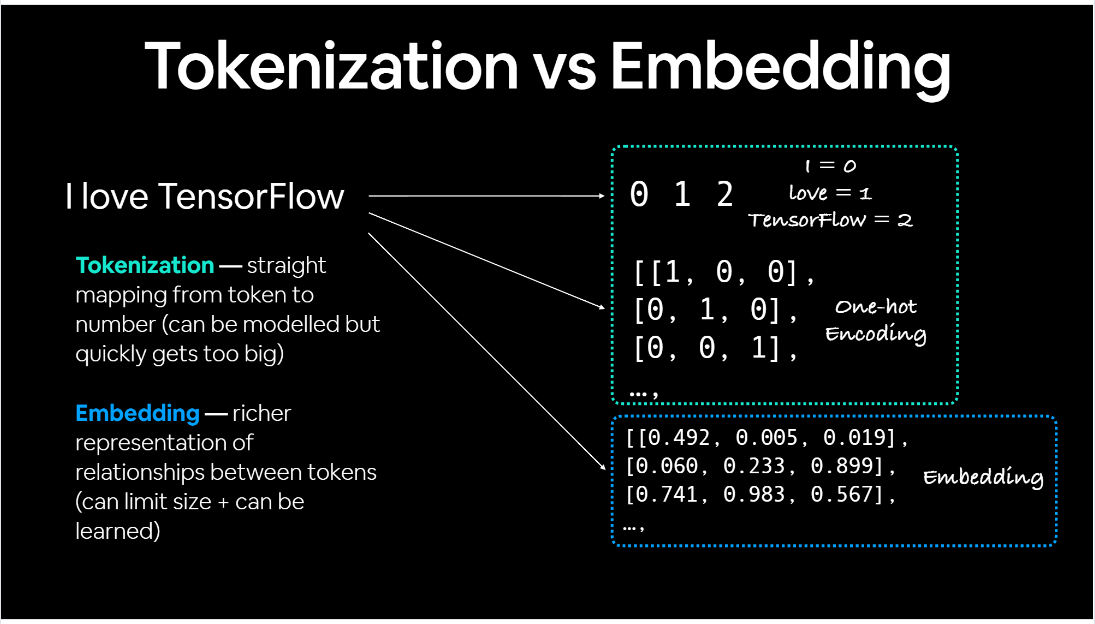

## Text vectorization (tokenization)

In [14]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split='whitespace',
                                    ngrams=None, # create groups of n-words
                                    output_mode='int', # how to map tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be?
                                    pad_to_max_tokens=False)

In [16]:
train_sentences[:2]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma'], dtype=object)

In [17]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [18]:
# Setup text vectorization variables
max_vocab_length = 10000 # max no. of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_sequence_length = max_length,
                                    pad_to_max_tokens=True)

In [19]:
# Fit the text vectorizer to the training set
text_vectorizer.adapt(train_sentences)

In [20]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [21]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 Men escape car engulfed in flames in Parley's Canyon crews investigating cause - http://t.co/tFan6qq2Ys http://t.co/rAkwWritPo      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 646, 1084,  127,  436,    4,  218,    4, 2025, 1704,  689, 1130,
         257,    1,    1,    0]])>

In [22]:
# Get the unique words in the vocabulary 
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in training data
top_5_words = words_in_vocab[:5] # get the most common words
print(f"Number of words in vocab: {len(words_in_vocab)}\n")
print(f"5 Most common words: {words_in_vocab[:5]}\n")
print(f"5 Least common words: {words_in_vocab[-5:]}") # get the least common words


Number of words in vocab: 10000

5 Most common words: ['', '[UNK]', 'the', 'a', 'in']

5 Least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make our Embedding, we're going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim`: the size of the vocabulary
* `output_dim`: the size of the output embedding vector, for example a value of 100 would mean each token gets represented by a vector 100 long 
* `input_length`: length of the sequences being passed to the embedding layer

In [23]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # sets input shape
                             output_dim=128, # output shape
                             input_length=max_length) # how long is each input

In [24]:
# Get a random sentence from the training sentence
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
      \n\n Embedded Version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 Any lengths to rescue a cat in need! http://t.co/AMroX4Y4Nx      

 Embedded Version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.0412724 , -0.00390062, -0.0343429 , ..., -0.03801496,
          0.04749817,  0.02461677],
        [ 0.01684371,  0.02970532,  0.0228962 , ...,  0.01925487,
         -0.03684207, -0.03093982],
        [ 0.04726047,  0.0032838 ,  0.03609146, ...,  0.00355928,
          0.04308042, -0.0148942 ],
        ...,
        [ 0.01175325,  0.03297755, -0.04620258, ...,  0.04924996,
          0.00317696,  0.0238358 ],
        [ 0.01175325,  0.03297755, -0.04620258, ...,  0.04924996,
          0.00317696,  0.0238358 ],
        [ 0.01175325,  0.03297755, -0.04620258, ...,  0.04924996,
          0.00317696,  0.0238358 ]]], dtype=float32)>

In [25]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-4.1272402e-02, -3.9006248e-03, -3.4342900e-02,  2.2684697e-02,
         1.7607477e-02,  2.6135508e-02, -3.4487151e-02,  4.5555521e-02,
         4.3274883e-02,  1.6735680e-03,  6.9209710e-03, -3.7692077e-03,
         3.8451444e-02, -1.5547760e-03, -3.6591720e-02, -4.2059112e-02,
         3.9326657e-02, -3.3479560e-02,  4.9466003e-02, -6.9496036e-03,
         4.9387906e-02,  1.8995404e-03,  6.0425401e-03,  1.2753159e-04,
         3.3326183e-02,  2.5334325e-02,  1.1218358e-02, -4.4551063e-02,
         1.2057982e-02,  1.9190993e-02,  4.9214054e-02, -2.8588548e-03,
        -1.5409984e-02, -3.1572893e-02,  3.7201080e-02,  1.1933554e-02,
        -2.6561415e-02,  3.6760401e-02, -5.2957423e-03, -3.9061546e-02,
         1.7199818e-02, -2.1421909e-02,  8.8956207e-04, -2.3637641e-02,
         3.6904443e-02, -4.1542102e-02, -4.3553520e-02,  4.1735891e-02,
        -5.8087222e-03, -3.6056221e-02, -2.7335692e-02,  1.9582462e-02,
        -1.2313

## Modelling a text dataset (running a series of experiments)

Now we've got a way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive-Bayes (baseline), this is from [Sklearn ML map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: Tensorflow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of the training data

How are we going to approach all these?

Use the standard steps in modelling with tensorflow:

* Create a model
* Build a model
* Fit a model
* Evaluate a model

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> **Note:** It's common practise to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ('tfidf',TfidfVectorizer()), # convert words to numbers usinf tfidf
                    ('clf',MultinomialNB()) # model the text
])
# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [29]:
# Evaluate the baseline model
baseline_score = model_0.score(val_sentences,val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [31]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])